In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1


In [5]:
positive_dir = Path('/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1/Positive')
negative_dir = Path('/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1/Negative')

In [6]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [7]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
df

,Filepath,Label
0,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
1,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
2,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
3,/root/.cache/kagglehub/datasets/arunrk7/surfac...,NEGATIVE
4,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
...,...,...
39995,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
39996,/root/.cache/kagglehub/datasets/arunrk7/surfac...,NEGATIVE
39997,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE
39998,/root/.cache/kagglehub/datasets/arunrk7/surfac...,POSITIVE


In [8]:
train_df, test_df = train_test_split(df,train_size=0.7,shuffle=True,random_state=42)

In [9]:
train_df.shape

(28000, 2)

In [10]:
test_df.shape

(12000, 2)

**Image Data Generator generates batches of tensor image data with real-time data augmentation.**

**For more insights check the tensorflow official documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator**

In [11]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

**flow_from_dataframe checks the path available on the dataframe and then automatically search for the image in train directory. Then it make the desired preprocessing steps available in ImageDataGenerator**

**More insights can be found from this article https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1**

In [12]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

Found 22400 validated image filenames belonging to 2 classes.


In [13]:
val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 5600 validated image filenames belonging to 2 classes.


In [14]:
test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42)

Found 12000 validated image filenames belonging to 2 classes.


**Training the model**

In [15]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

None


**Fitting the model**

In [26]:
history = model.fit(train_data,validation_data=val_data,epochs=3,
            callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)])

Epoch 1/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.9686 - loss: 0.1041 - val_accuracy: 0.9748 - val_loss: 0.0761
Epoch 2/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 0.9759 - loss: 0.0793 - val_accuracy: 0.9729 - val_loss: 0.0753
Epoch 3/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 150s 215ms/step - accuracy: 0.9756 - loss: 0.0793 - val_accuracy: 0.9804 - val_loss: 0.0621


**At the end of 10th epoch we are getting an accuracy of 0.9793 and validation accuracy of 0.9759**

In [27]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time")
fig.show()

In [28]:
fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "Accuracy"},
    title="Training and Validation Accuracy Over Time")
fig.show()

In [29]:
def evaluate_model(model, test_data):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

In [30]:
evaluate_model(model, test_data)

    Test Loss: 0.07303
Test Accuracy: 98.13%


**Test accuracy is 97.91% and Test loss is 0.05720**

375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step


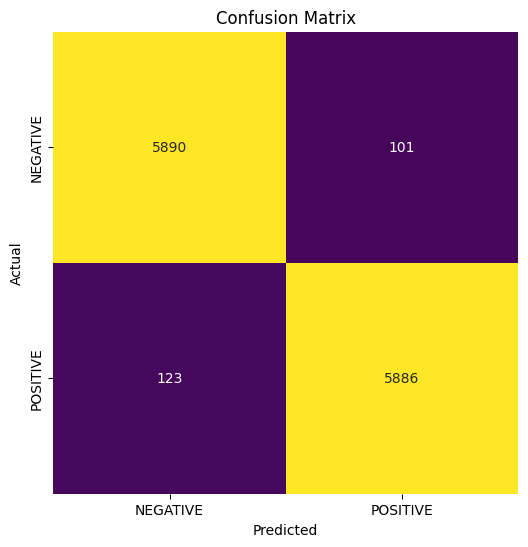

In [31]:
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
cm = confusion_matrix(test_data.labels, y_pred)
clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**We got 11749 correct predictions out of 12000 records in test set.**

In [32]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.98      0.98      5991
    POSITIVE       0.98      0.98      0.98      6009

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [33]:
tf.keras.models.save_model(model, "crack_detection_model.h5") # Added the model object/variable to the save_model function call

In [37]:
# prompt: how to use the model on a image which is uploaded by the user

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model("crack_detection_model.h5")

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(120, 120))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize the image

    prediction = model.predict(x)
    probability = prediction[0][0]

    if probability >= 0.5:
        predicted_class = "POSITIVE"
    else:
        predicted_class = "NEGATIVE"

    return predicted_class, probability


# Example usage (replace with user uploaded image path)
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  predicted_class, probability = predict_image(fn)

  print(f"Predicted Class: {predicted_class}")
  print(f"Probability: {probability}")


Saving 00006.jpg to 00006.jpg
User uploaded file "00006.jpg" with length 4770 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted Class: POSITIVE
Probability: 0.8664540648460388
